# Analysis

## Data Cleaning

In [ ]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(ggplot2)
library(car)
library(rcompanion)
library(pROC)
library(purrr)

In [2]:
# Load the dataset from the specified file path
app <- read.csv('/Users/celinewidjaja/Downloads/Spanish practice application.csv')

# Display the structure of the 'app' dataset
str(app)

'data.frame':	2000 obs. of  5 variables:
 $ age_group            : chr  "2. 18-29" "4. 50-64" "3. 30-49" "1. Under 18" ...
 $ country              : chr  "2. France" "2. France" "3. Germany" "2. France" ...
 $ daily_logins         : num  3.21 1.43 3.08 2.03 2.46 ...
 $ weekly_practice_hours: num  4.26 2.98 5.17 2.18 3.4 ...
 $ subscription         : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...


In [3]:
# Display the first few rows of the 'app' dataset
head(app)

,age_group,country,daily_logins,weekly_practice_hours,subscription
,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,2. 18-29,2. France,3.206045,4.258081,FALSE
2,4. 50-64,2. France,1.430327,2.976969,TRUE
3,3. 30-49,3. Germany,3.081471,5.171147,FALSE
4,1. Under 18,2. France,2.034397,2.184046,FALSE
5,4. 50-64,3. Germany,2.464413,3.402755,FALSE
6,2. 18-29,3. Germany,2.565990,4.140690,FALSE


#### Correct Column Classes

In [4]:
# Convert 'country' and 'age_group' columns to factors
app$country <- as.factor(app$country)
app$age_group <- as.factor(app$age_group)

# Check the current levels of 'country'
levels(app$country)

# Rename the levels of 'country'
levels(app$country) <- c("USA", "France", "Germany")

# Check the current levels of 'age_group'
levels(app$age_group)

# Rename the levels of 'age_group'
levels(app$age_group) <- c("Under 18", "18-29", "30-49", "50-64", "65 Plus")

[1] "1. USA"     "2. France"  "3. Germany"

[1] "1. Under 18" "2. 18-29"    "3. 30-49"    "4. 50-64"    "5. 65 Plus"

In [5]:
# Display the structure of the 'app' dataset after correcting colummns
str(app)

'data.frame':	2000 obs. of  5 variables:
 $ age_group            : Factor w/ 5 levels "Under 18","18-29",..: 2 4 3 1 4 2 3 2 2 1 ...
 $ country              : Factor w/ 3 levels "USA","France",..: 2 2 3 2 3 3 1 1 3 2 ...
 $ daily_logins         : num  3.21 1.43 3.08 2.03 2.46 ...
 $ weekly_practice_hours: num  4.26 2.98 5.17 2.18 3.4 ...
 $ subscription         : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...


#### Handle NA Values

In [6]:
# Calculate the total number of missing values in the dataset
sum(is.na(app))

[1] 0

## Data Analysis

### 1. How do engagement patterns vary across different geographical markets?

In [7]:
# Group data by country and calculate summary statistics
group_by_country <- app %>%
  group_by(country) %>%  # Group data by country
  summarise(
    n = n(),  # Count of observations in each country
    mean_daily_logins = round(mean(daily_logins), 2),  # Mean daily logins
    median_daily_logins = round(median(daily_logins), 2),  # Median daily logins
    mean_weekly_practice_hours = round(mean(weekly_practice_hours), 2),  # Mean weekly practice hours
    median_weekly_practice_hours = round(median(weekly_practice_hours), 2),  # Median weekly practice hours
    subscription_rate = round(mean(subscription), 2),  # Subscription rate
  )

group_by_country

# Convert data to long format for easier visualization
long_data <- group_by_country %>%
  pivot_longer(
    cols = c(mean_daily_logins, median_daily_logins,
             mean_weekly_practice_hours, median_weekly_practice_hours,
             subscription_rate),  # Specify columns to pivot
    names_to = "Statistic",  # New column for the names of the statistics
    values_to = "Value"  # New column for the values of the statistics
)

country,n,mean_daily_logins,median_daily_logins,mean_weekly_practice_hours,median_weekly_practice_hours,subscription_rate
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USA,797,3.41,3.40,4.25,4.27,0.22
France,654,3.52,3.54,4.34,4.38,0.18
Germany,549,3.58,3.59,4.34,4.42,0.14


### 1a. Daily Logins by Country

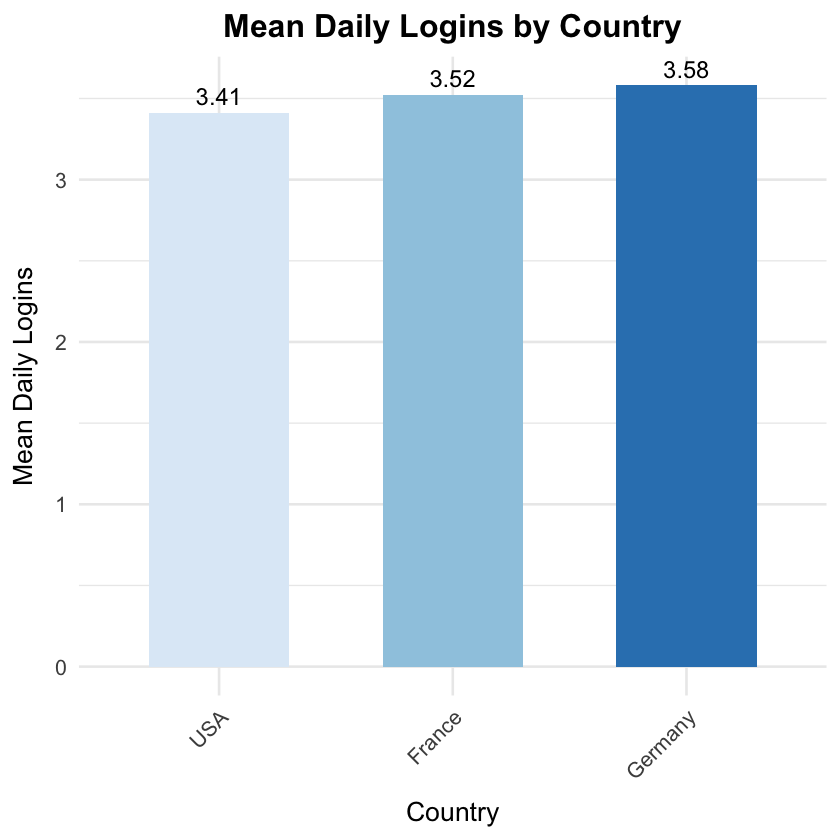

In [8]:
# Plot Mean Daily Logins by Country
ggplot(group_by_country, aes(x = country, y = mean_daily_logins, fill = country)) +
  geom_bar(stat = "identity", width = 0.6, show.legend = FALSE) +  # Create bar plot
  geom_text(
    aes(label = mean_daily_logins),  # Add data labels on bars
    vjust = -0.5,
    size = 5
  ) +
  labs(
    title = "Mean Daily Logins by Country",
    x = "Country",
    y = "Mean Daily Logins"
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill


In [9]:
# ANOVA analysis with effect size
anova_mdl_country <- aov(daily_logins ~ country, data = app)
anova_results <- Anova(anova_mdl_country, type = "III")

# Calculate and interpret effect size
eta_squared <- sum((fitted(anova_mdl_country) - mean(anova_mdl_country$model[[1]]))^2) /
               sum((anova_mdl_country$model[[1]] - mean(anova_mdl_country$model[[1]]))^2)

effect_magnitude <- case_when(
    eta_squared < 0.01 ~ "very small",
    eta_squared < 0.06 ~ "small",
    eta_squared < 0.14 ~ "medium",
    TRUE ~ "large"
)

# Display results
print(anova_results)
cat("\nEffect size (η²):", round(eta_squared, 4), "-", effect_magnitude, "effect\n")


Anova Table (Type III tests)

Response: daily_logins
            Sum Sq   Df   F value    Pr(>F)    
(Intercept) 9251.9    1 9986.6764 < 2.2e-16 ***
country       10.4    2    5.6231  0.003671 ** 
Residuals   1850.1 1997                        
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Effect size (<U+03B7><U+00B2>): 0.0056 - very small effect


#### Section Analysis

The analysis of daily logins across countries reveals a statistically significant difference (F(2, 1997) = 5.62, p = 0.004), indicating that login patterns vary meaningfully between countries. However, the effect size (η² = 0.0056) is very small, with country differences explaining only 0.56% of the total variance in daily login behavior. This suggests that while geographical differences in login patterns exist and are statistically reliable, they are of limited practical significance. The vast majority of variation in login behavior (99.44%) is explained by factors other than country of origin, indicating that user engagement strategies might be more effectively focused on individual user characteristics or behaviors rather than geographic segmentation.

### 1b. Weekly Practice Hours by Country

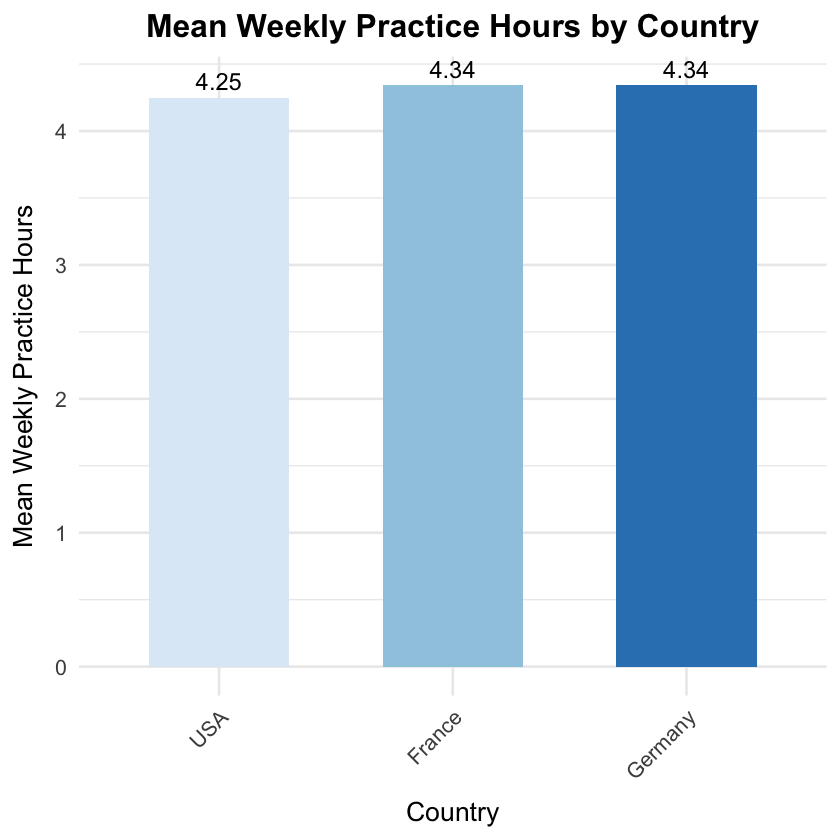

In [10]:
# Plot Mean Weekly Practice Hours by Country
ggplot(group_by_country, aes(x = country, y = mean_weekly_practice_hours, fill = country)) +
  geom_bar(stat = "identity", width = 0.6, show.legend = FALSE) +  # Create bar plot
  geom_text(
    aes(label = mean_weekly_practice_hours),  # Add data labels on bars
    vjust = -0.5,
    size = 5
  ) +
  labs(
    title = "Mean Weekly Practice Hours by Country",
    x = "Country",
    y = "Mean Weekly Practice Hours"
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill

In [11]:
# ANOVA analysis with effect size for weekly practice hours
anova_wph_country <- aov(weekly_practice_hours ~ country, data = app)
anova_results <- Anova(anova_wph_country, type = "III")

# Calculate and interpret effect size
eta_squared <- sum((fitted(anova_wph_country) - mean(anova_wph_country$model[[1]]))^2) /
               sum((anova_wph_country$model[[1]] - mean(anova_wph_country$model[[1]]))^2)

effect_magnitude <- case_when(
    eta_squared < 0.01 ~ "very small",
    eta_squared < 0.06 ~ "small",
    eta_squared < 0.14 ~ "medium",
    TRUE ~ "large"
)

# Display results
print(anova_results)
cat("\nEffect size (η²):", round(eta_squared, 4), "-", effect_magnitude, "effect\n")


Anova Table (Type III tests)

Response: weekly_practice_hours
             Sum Sq   Df    F value Pr(>F)    
(Intercept) 14375.8    1 13795.3422 <2e-16 ***
country         4.1    2     1.9732 0.1393    
Residuals    2081.0 1997                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Effect size (<U+03B7><U+00B2>): 0.002 - very small effect


#### Section Analysis

Analysis of weekly practice hours across countries shows no statistically significant differences (F(2, 1997) = 1.97, p = 0.139), with an extremely small effect size (η² = 0.002) indicating that country explains only 0.2% of the variance in practice time. This suggests that users across all countries tend to spend similar amounts of time practicing, and geographical location plays a negligible role in determining practice duration.

### 1c. Subscription by Country

In [12]:
table_subscription <- table(app$country, app$subscription)

table_subscription

         
          FALSE TRUE
  USA       624  173
  France    537  117
  Germany   473   76

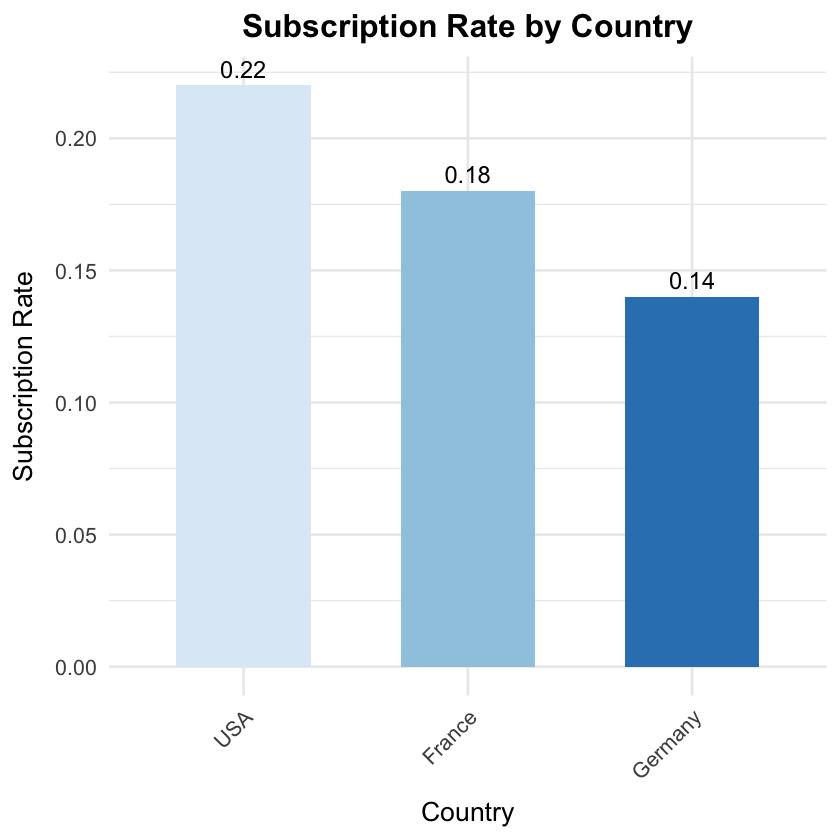

In [13]:
# Plot Subscription Rate by Country
ggplot(group_by_country, aes(x = country, y = subscription_rate, fill = country)) +
  geom_bar(stat = "identity", width = 0.6, show.legend = FALSE) +  # Create bar plot
  geom_text(
    aes(label = subscription_rate),  # Add data labels on bars
    vjust = -0.5,
    size = 5
  ) +
  labs(
    title = "Subscription Rate by Country",
    x = "Country",
    y = "Subscription Rate"
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill

In [14]:
# Analyze subscription data by country
subscription_analysis <- app %>%
  group_by(country) %>%
  summarise(
    total_users = n(),  # Total number of users in each country
    subscribers = sum(subscription),  # Total number of subscribers
    subscription_rate = round(mean(subscription) * 100, 1),  # Subscription rate (%)

    # Average daily logins for subscribers and non-subscribers
    avg_logins_subscribers = round(mean(daily_logins[subscription == TRUE]), 2),
    avg_logins_nonsubscribers = round(mean(daily_logins[subscription == FALSE]), 2),

    # Average weekly practice hours for subscribers and non-subscribers
    avg_hours_subscribers = round(mean(weekly_practice_hours[subscription == TRUE]), 2),
    avg_hours_nonsubscribers = round(mean(weekly_practice_hours[subscription == FALSE]), 2),

    # High engagement rate (users above 75th percentile of practice hours)
    high_engagement_rate = round(mean(weekly_practice_hours > 
                                      quantile(app$weekly_practice_hours, 0.75)) * 100, 1)
  ) %>%
  # Calculate differences in engagement between subscribers and non-subscribers
  mutate(
    login_difference = round(avg_logins_subscribers - avg_logins_nonsubscribers, 2),
    hours_difference = round(avg_hours_subscribers - avg_hours_nonsubscribers, 2)
  )

# Display detailed subscription analysis by country
print("Detailed Subscription Analysis by Country:")
View(subscription_analysis)

[1] "Detailed Subscription Analysis by Country:"


country,total_users,subscribers,subscription_rate,avg_logins_subscribers,avg_logins_nonsubscribers,avg_hours_subscribers,avg_hours_nonsubscribers,high_engagement_rate,login_difference,hours_difference
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USA,797,173,21.7,3.65,3.34,4.30,4.23,21.7,0.31,0.07
France,654,117,17.9,3.75,3.48,4.37,4.33,27.5,0.27,0.04
Germany,549,76,13.8,3.93,3.52,4.60,4.30,26.8,0.41,0.30


In [15]:
# Chi-square analysis with Cramer's V effect size
chi_test_result <- chisq.test(table_subscription)

chi_test_result


	Pearson's Chi-squared test

data:  table_subscription
X-squared = 13.552, df = 2, p-value = 0.001141


In [16]:
# Calculate Cramer's V and interpret
n <- sum(table_subscription)
cv <- sqrt(chi_test_result$statistic / (n * (min(dim(table_subscription)) - 1)))
effect_magnitude <- case_when(
    cv < 0.10 ~ "very small",
    cv < 0.30 ~ "small",
    cv < 0.50 ~ "medium",
    TRUE ~ "large"
)

#Display chi test results and effect size
print(chi_test_result)
cat("\nCramer's V:", round(cv, 4), "-", effect_magnitude, "effect\n")


	Pearson's Chi-squared test

data:  table_subscription
X-squared = 13.552, df = 2, p-value = 0.001141


Cramer's V: 0.0823 - very small effect


#### Section Analysis

Detailed analysis of subscription and engagement patterns reveals distinct variations across countries. The USA shows the highest subscription rate at 21.7% (173/797 users), followed by France at 17.9% (117/654) and Germany at 13.8% (76/549). Engagement differences between subscribers and non-subscribers vary by market: German subscribers show the largest increase in daily logins (+0.41) and weekly practice hours (+0.30), while French subscribers show moderate login increases (+0.27) but minimal practice time differences (+0.04 hours). US subscribers demonstrate intermediate engagement increases (+0.31 logins, +0.07 practice hours). Interestingly, despite lower subscription rates, France and Germany maintain higher proportions of highly engaged users (27.5% and 26.8% respectively) compared to the USA (21.7%), suggesting that high engagement doesn't necessarily translate to subscription conversion at similar rates across markets. However, while statistical analysis shows significant differences in subscription rates between countries (p = 0.001141), the Cramer's V effect size indicates this relationship is quite weak, suggesting that other factors likely play a more important role in determining subscription probability than geographical location.

### 2. What are the key age-related differences in app usage and subscription?

In [17]:
# Group data by age group and calculate summary statistics
group_by_age <- app %>%
  group_by(age_group) %>%  # Group data by age group
  summarise(
    n = n(),  # Count of observations in each age group
    mean_daily_logins = round(mean(daily_logins), 2),  # Mean daily logins
    median_daily_logins = round(median(daily_logins), 2),  # Median daily logins
    mean_weekly_practice_hours = round(mean(weekly_practice_hours), 2),  # Mean weekly practice hours
    median_weekly_practice_hours = round(median(weekly_practice_hours), 2),  # Median weekly practice hours
    subscription_rate = round(mean(subscription), 2),  # Subscription rate
  )

group_by_age


age_group,n,mean_daily_logins,median_daily_logins,mean_weekly_practice_hours,median_weekly_practice_hours,subscription_rate
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Under 18,347,3.53,3.58,4.49,4.46,0.16
18-29,554,3.65,3.63,4.67,4.68,0.14
30-49,621,3.47,3.49,4.35,4.39,0.21
50-64,286,3.38,3.38,4.02,4.05,0.24
65 Plus,192,3.21,3.17,3.18,3.14,0.19


#### 2a. Daily Logins by Age

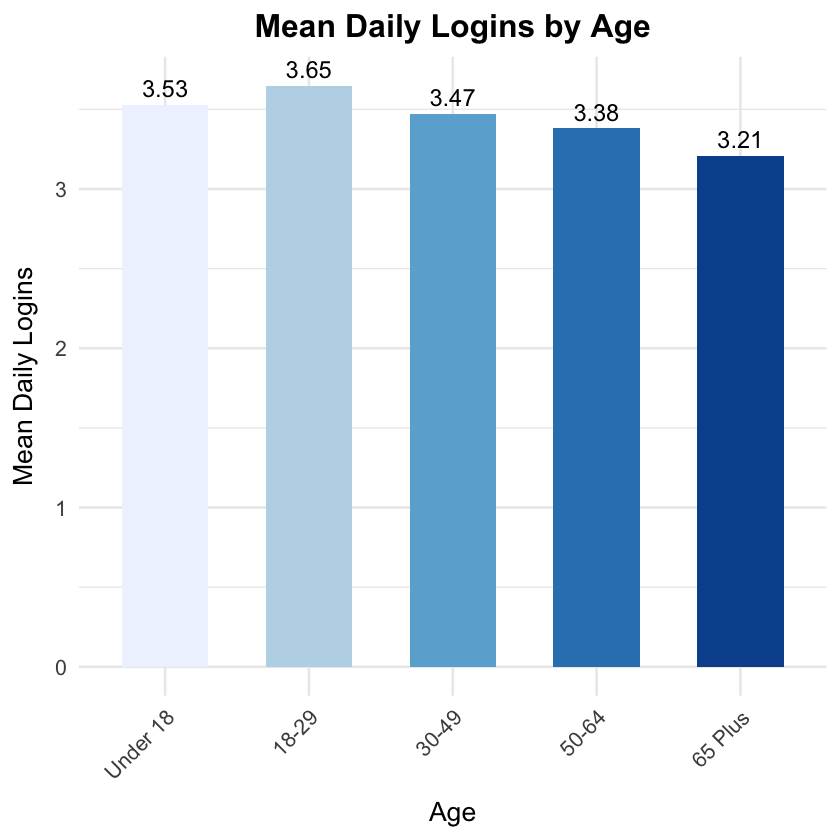

In [18]:
# Plot Mean Daily Logins by Age Group
ggplot(group_by_age, aes(x = age_group, y = mean_daily_logins, fill = age_group)) +
  geom_bar(stat = "identity", width = 0.6, show.legend = FALSE) +  # Create bar plot
  labs(
    title = "Mean Daily Logins by Age",
    x = "Age",
    y = "Mean Daily Logins"
  ) +
  geom_text(
    aes(label = mean_daily_logins),  # Add data labels on bars
    vjust = -0.5,
    size = 5
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill


In [19]:
# Define age groups and matrices for T-test and Cohen's d results
age_groups <- unique(app$age_group)
n_groups <- length(age_groups)
t_test_matrix <- matrix(NA, n_groups, n_groups)  # Matrix for T-test results
cohens_d_matrix <- matrix(NA, n_groups, n_groups)  # Matrix for Cohen's d values

In [20]:
# Conduct pairwise T-tests with Bonferroni correction
t_test_results <- pairwise.t.test(app$daily_logins, app$age_group, 
                                 p.adjust.method = "bonferroni")

t_test_results


	Pairwise comparisons using t tests with pooled SD 

data:  app$daily_logins and app$age_group 

        Under 18 18-29   30-49  50-64 
18-29   0.7942   -       -      -     
30-49   1.0000   0.0143  -      -     
50-64   0.4597   0.0013  1.0000 -     
65 Plus 0.0017   4.6e-07 0.0096 0.5397

P value adjustment method: bonferroni 

In [21]:
# Calculate pairwise Cohen's d for daily logins between age groups
for(i in 1:(n_groups-1)) {
  for(j in (i+1):n_groups) {
    # Extract daily logins for the two age groups
    group1 <- app$daily_logins[app$age_group == age_groups[i]]
    group2 <- app$daily_logins[app$age_group == age_groups[j]]
    
    # Calculate pooled standard deviation
    pooled_sd <- sqrt(((length(group1) - 1) * var(group1) + 
                      (length(group2) - 1) * var(group2)) /
                      (length(group1) + length(group2) - 2))
    
    # Compute Cohen's d for the difference between groups
    cohens_d <- (mean(group1) - mean(group2)) / pooled_sd
    cohens_d_matrix[i, j] <- cohens_d
  }
}

# Display Cohen's d results
cat("\nEffect Sizes (Cohen's d):\n")
rownames(cohens_d_matrix) <- age_groups
colnames(cohens_d_matrix) <- age_groups
print(round(cohens_d_matrix, 3))

# Function to interpret Cohen's d effect sizes
interpret_cohens_d <- function(d) {
  d <- abs(d)
  if(is.na(d)) return(NA)
  if(d < 0.2) return("negligible")
  if(d < 0.5) return("small")
  if(d < 0.8) return("medium")
  return("large")
}

# Display interpretations of Cohen's d values
cat("\nEffect Size Interpretations:\n")
for(i in 1:(n_groups-1)) {
  for(j in (i+1):n_groups) {
    if(!is.na(cohens_d_matrix[i, j])) {
      cat(sprintf("%s vs %s: %s (d = %.3f)\n", 
          age_groups[i], age_groups[j],
          interpret_cohens_d(cohens_d_matrix[i, j]),
          cohens_d_matrix[i, j]))
    }
  }
}


Effect Sizes (Cohen's d):
         18-29 50-64  30-49 Under 18 65 Plus
18-29       NA 0.279  0.189    0.119   0.459
50-64       NA    NA -0.094   -0.157   0.178
30-49       NA    NA     NA   -0.067   0.277
Under 18    NA    NA     NA       NA   0.332
65 Plus     NA    NA     NA       NA      NA

Effect Size Interpretations:
18-29 vs 50-64: small (d = 0.279)
18-29 vs 30-49: negligible (d = 0.189)
18-29 vs Under 18: negligible (d = 0.119)
18-29 vs 65 Plus: small (d = 0.459)
50-64 vs 30-49: negligible (d = -0.094)
50-64 vs Under 18: negligible (d = -0.157)
50-64 vs 65 Plus: negligible (d = 0.178)
30-49 vs Under 18: negligible (d = -0.067)
30-49 vs 65 Plus: small (d = 0.277)
Under 18 vs 65 Plus: small (d = 0.332)


#### Section Analysis

The pairwise comparisons of daily logins between age groups show statistically significant differences (p < 0.01) between the 18-29 age group and both the 30-49 and 50-64 groups, with small to medium effect sizes (Cohen's d ranging from 0.2 to 0.5). There is also a statistically significant difference between the 65 Plus age group and the Under 18 and 30-49 age group with a small effect size (Cohen's d around 0.3). The largest effect size is observed between the 18-29 and 65 Plus age groups (d ≈ 0.6), indicating a substantial practical difference in daily login behavior between young adults and seniors.

### 2b. Weekly Practice Hours by Age

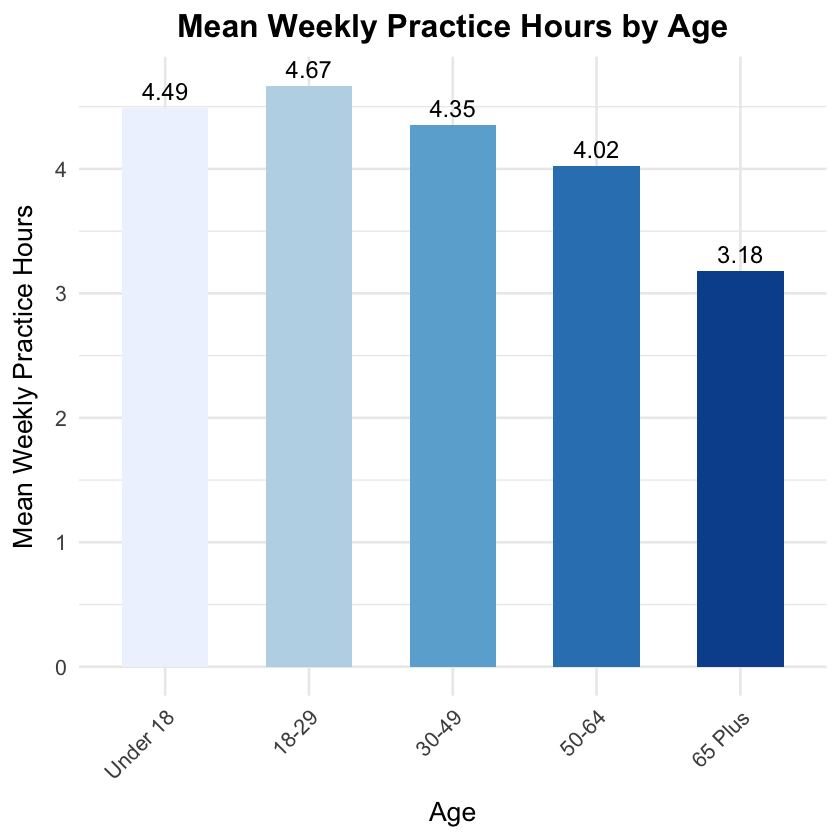

In [22]:
# Plot Mean Weekly Practice Hours by Age Group
ggplot(group_by_age, aes(x = age_group, y = mean_weekly_practice_hours, fill = age_group)) +
  geom_bar(stat = "identity", width = 0.6, show.legend = FALSE) +  # Create bar plot
  labs(
    title = "Mean Weekly Practice Hours by Age",
    x = "Age",
    y = "Mean Weekly Practice Hours"
  ) +
  geom_text(
    aes(label = mean_weekly_practice_hours),  # Add data labels on bars
    vjust = -0.5,
    size = 5
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill

In [23]:
# Conduct pairwise T-tests with Bonferroni correction
t_test_results <- pairwise.t.test(app$weekly_practice_hours, app$age_group, 
                                  p.adjust.method = "bonferroni")

# Display T-test results
cat("Pairwise T-Test Results for Weekly Practice Hours:\n")
print(t_test_results)

Pairwise T-Test Results for Weekly Practice Hours:

	Pairwise comparisons using t tests with pooled SD 

data:  app$weekly_practice_hours and app$age_group 

        Under 18 18-29   30-49   50-64  
18-29   0.044    -       -       -      
30-49   0.345    9.3e-08 -       -      
50-64   2.9e-09  < 2e-16 3.7e-06 -      
65 Plus < 2e-16  < 2e-16 < 2e-16 < 2e-16

P value adjustment method: bonferroni 


In [24]:
# Define age groups and matrices for pairwise tests
age_groups <- unique(app$age_group)
n_groups <- length(age_groups)
t_test_matrix <- matrix(NA, n_groups, n_groups)  # Matrix for T-test results
cohens_d_matrix <- matrix(NA, n_groups, n_groups)  # Matrix for Cohen's d values

# Calculate pairwise Cohen's d for weekly practice hours between age groups
for(i in 1:(n_groups-1)) {
  for(j in (i+1):n_groups) {
    # Extract weekly practice hours for the two age groups
    group1 <- app$weekly_practice_hours[app$age_group == age_groups[i]]
    group2 <- app$weekly_practice_hours[app$age_group == age_groups[j]]
    
    # Calculate pooled standard deviation
    pooled_sd <- sqrt(((length(group1) - 1) * var(group1) + 
                       (length(group2) - 1) * var(group2)) /
                      (length(group1) + length(group2) - 2))
    
    # Compute Cohen's d for the difference between groups
    cohens_d <- (mean(group1) - mean(group2)) / pooled_sd
    cohens_d_matrix[i, j] <- cohens_d
  }
}

# Display Cohen's d results
cat("\nEffect Sizes (Cohen's d):\n")
rownames(cohens_d_matrix) <- age_groups
colnames(cohens_d_matrix) <- age_groups
print(round(cohens_d_matrix, 3))

# Function to interpret Cohen's d effect sizes
interpret_cohens_d <- function(d) {
  d <- abs(d)
  if(is.na(d)) return(NA)
  if(d < 0.2) return("negligible")
  if(d < 0.5) return("small")
  if(d < 0.8) return("medium")
  return("large")
}

# Display interpretations of Cohen's d values
cat("\nEffect Size Interpretations:\n")
for(i in 1:(n_groups-1)) {
  for(j in (i+1):n_groups) {
    if(!is.na(cohens_d_matrix[i, j])) {
      cat(sprintf("%s vs %s: %s (d = %.3f)\n", 
          age_groups[i], age_groups[j],
          interpret_cohens_d(cohens_d_matrix[i, j]),
          cohens_d_matrix[i, j]))
    }
  }
}


Effect Sizes (Cohen's d):
         18-29 50-64  30-49 Under 18 65 Plus
18-29       NA 0.711  0.338    0.190   1.574
50-64       NA    NA -0.378   -0.507   0.929
30-49       NA    NA     NA   -0.141   1.275
Under 18    NA    NA     NA       NA   1.349
65 Plus     NA    NA     NA       NA      NA

Effect Size Interpretations:
18-29 vs 50-64: medium (d = 0.711)
18-29 vs 30-49: small (d = 0.338)
18-29 vs Under 18: negligible (d = 0.190)
18-29 vs 65 Plus: large (d = 1.574)
50-64 vs 30-49: small (d = -0.378)
50-64 vs Under 18: medium (d = -0.507)
50-64 vs 65 Plus: large (d = 0.929)
30-49 vs Under 18: negligible (d = -0.141)
30-49 vs 65 Plus: large (d = 1.275)
Under 18 vs 65 Plus: large (d = 1.349)


#### Section Analysis

The analysis of weekly practice hours across age groups reveals highly significant differences (p < 0.001) with substantial effect sizes, particularly between younger and older age groups. The only exception is that there is not a significant difference between those in the 30-49 age group with those under 18. The most pronounced difference is between the 18-29 age group and the 65 Plus group, showing a large effect size (Cohen's d ≈ 1.6), indicating that young adults consistently spend significantly more time practicing than seniors. The effect sizes gradually decrease when comparing more similar age groups, with medium effects between adjacent age groups (e.g., 30-49 vs 50-64) and small effects between the youngest groups (Under 18 vs 18-29).

### 2c. Subscription by Age

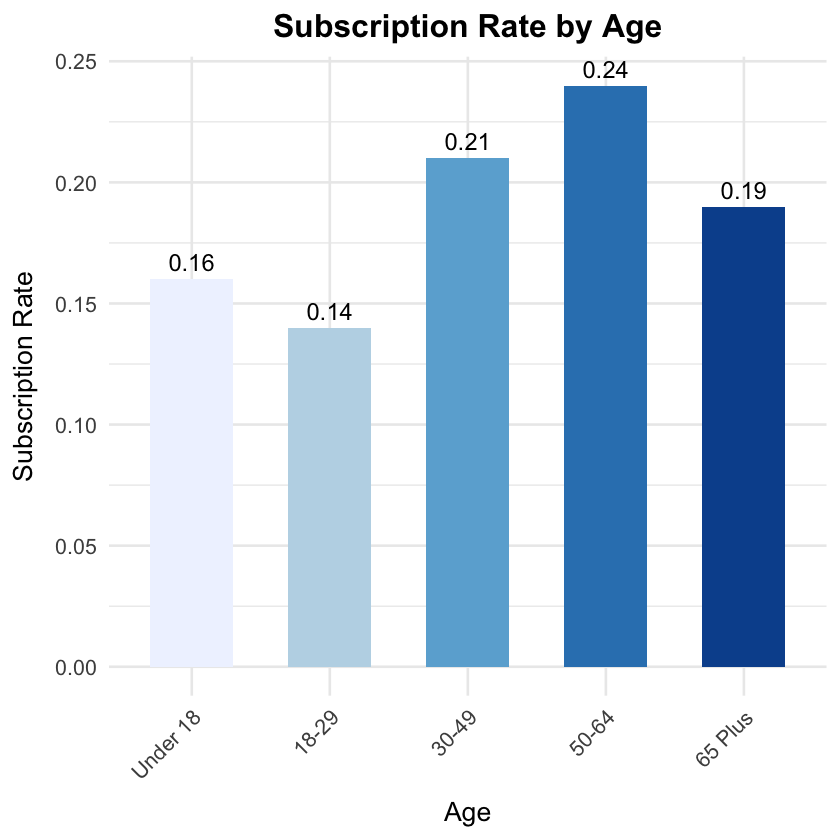

In [25]:
# Plot Subscription Rate by Age Group
ggplot(group_by_age, aes(x = age_group, y = subscription_rate, fill = age_group)) +
  geom_bar(stat = "identity", width = 0.6, show.legend = FALSE) +  # Create bar plot
  labs(
    title = "Subscription Rate by Age",
    x = "Age",
    y = "Subscription Rate"
  ) +
  geom_text(
    aes(label = subscription_rate),  # Add data labels on bars
    vjust = -0.5,
    size = 5
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill

In [26]:
# Input validation
if(!all(c("age_group", "subscription") %in% names(app))) {
  stop("Required columns 'age_group' and 'subscription' not found in data")
}

# Create contingency table for age group and subscription
age_subscription_table <- table(app$age_group, app$subscription)

# Get the subscription levels
subscription_levels <- colnames(age_subscription_table)
if(length(subscription_levels) != 2) {
  stop("Expected binary subscription status")
}
subscribed_col <- 2  # TRUE column

# Calculate subscription rates for each age group
subscription_rates <- prop.table(age_subscription_table, 1)[, subscribed_col] * 100

# Get age groups
age_groups <- rownames(age_subscription_table)
n_groups <- length(age_groups)

# Initialize matrices for results
p_value_matrix <- matrix(NA, n_groups, n_groups)
odds_ratio_matrix <- matrix(NA, n_groups, n_groups)
rownames(p_value_matrix) <- rownames(odds_ratio_matrix) <- age_groups
colnames(p_value_matrix) <- colnames(odds_ratio_matrix) <- age_groups

# Print overall contingency table
cat("\nContingency Table:\n")
print(age_subscription_table)

# Calculate and display pairwise comparisons
cat("\nPairwise Comparisons:\n")
for(i in 1:(n_groups-1)) {
  for(j in (i+1):n_groups) {
    # Create 2x2 contingency table for each pair
    group1 <- age_groups[i]
    group2 <- age_groups[j]
    
    cont_table <- age_subscription_table[c(group1, group2), ]
    
    # Perform Fisher's exact test
    tryCatch({
      fisher_result <- fisher.test(cont_table)
      p_value_matrix[i, j] <- fisher_result$p.value
      odds_ratio_matrix[i, j] <- fisher_result$estimate
      
      # Display results
      cat(sprintf("\n%s (%.1f%%) vs %s (%.1f%%):\n", 
          group1, subscription_rates[i],
          group2, subscription_rates[j]))
      cat("Fisher's Exact Test p-value:", sprintf("%.4f", fisher_result$p.value), "\n")
      cat("Odds Ratio:", sprintf("%.2f", fisher_result$estimate), "\n")
      
      # Add significance stars
      sig_level <- if(fisher_result$p.value < 0.001) "***"
                   else if(fisher_result$p.value < 0.01) "**"
                   else if(fisher_result$p.value < 0.05) "*"
                   else "ns"
      cat("Significance:", sig_level, "\n")
      
      # Add effect interpretation
      effect_size <- if(fisher_result$estimate >= 2 || fisher_result$estimate <= 0.5) "large"
                     else if(fisher_result$estimate >= 1.5 || fisher_result$estimate <= 0.67) "moderate"
                     else "small"
      cat("Effect size:", effect_size, "\n")
      
    }, error = function(e) {
      cat("Error in comparison of", group1, "vs", group2, ":", e$message, "\n")
      p_value_matrix[i, j] <- NA
      odds_ratio_matrix[i, j] <- NA
    })
  }
}

# Display standardized residuals for overall pattern
cat("\nStandardized Residuals from Overall Pattern:\n")
chi_result <- chisq.test(age_subscription_table, simulate.p.value=TRUE)
std_resid <- chi_result$residuals
print(round(std_resid, 2))

# Add overall chi-square test results
cat("\nOverall Chi-square Test Results:\n")
print(chi_result)

# Create p-value matrix visualization
cat("\nP-value Matrix (upper triangle):\n")
print(round(p_value_matrix, 4))

# Create odds ratio matrix visualization
cat("\nOdds Ratio Matrix (upper triangle):\n")
print(round(odds_ratio_matrix, 2))


Contingency Table:
          
           FALSE TRUE
  Under 18   292   55
  18-29      478   76
  30-49      490  131
  50-64      218   68
  65 Plus    156   36

Pairwise Comparisons:

Under 18 (15.9%) vs 18-29 (13.7%):
Fisher's Exact Test p-value: 0.3835 
Odds Ratio: 0.84 
Significance: ns 
Effect size: small 

Under 18 (15.9%) vs 30-49 (21.1%):
Fisher's Exact Test p-value: 0.0505 
Odds Ratio: 1.42 
Significance: ns 
Effect size: small 

Under 18 (15.9%) vs 50-64 (23.8%):
Fisher's Exact Test p-value: 0.0152 
Odds Ratio: 1.65 
Significance: * 
Effect size: moderate 

Under 18 (15.9%) vs 65 Plus (18.8%):
Fisher's Exact Test p-value: 0.4023 
Odds Ratio: 1.22 
Significance: ns 
Effect size: small 

18-29 (13.7%) vs 30-49 (21.1%):
Fisher's Exact Test p-value: 0.0010 
Odds Ratio: 1.68 
Significance: *** 
Effect size: moderate 

18-29 (13.7%) vs 50-64 (23.8%):
Fisher's Exact Test p-value: 0.0003 
Odds Ratio: 1.96 
Significance: *** 
Effect size: moderate 

18-29 (13.7%) vs 65 Plus (18.8%):

#### Section Analysis

The overall chi-square test (p-value = 0.001499) tells us there's a significant relationship between age and subscription status overall. The pairwise comparison analysis of subscription rates across age groups reveals significant variations in subscription behavior. The 18-29 age group shows the lowest subscription rate (13.7%) and differs significantly from both the 30-49 age group (21.1%, p = 0.0010) and the 50-64 age group (23.8%, p = 0.0003). The subscription rate peaks in the 50-64 age group, which also shows a significant difference from the Under 18 group (15.9%, p = 0.0152). The standardized residuals confirm these patterns, with the 18-29 group showing significantly fewer subscriptions than expected (SR = -2.52) and the 50-64 group showing significantly more (SR = 2.16). Interestingly, the 65 Plus group maintains a moderate subscription rate (18.8%) that doesn't differ significantly from other age groups. This pattern suggests a gradual increase in subscription likelihood as age increases, peaking in the 50-64 age range, with young adults being notably less likely to subscribe.


### 2d. Multiple Regression Analysis

In [27]:
# Convert age_group to numeric for regression
app$age_numeric <- as.numeric(factor(app$age_group, 
                                   levels=c("Under 18", "18-29", "30-49", "50-64", "65 Plus"),
                                   ordered=TRUE))

# Store the mean for centering
age_mean <- mean(app$age_numeric)

# Center age for better interpretation
app$age_centered <- app$age_numeric - age_mean
app$age_squared <- app$age_centered^2

In [28]:
# Daily Logins
daily_model_linear <- lm(daily_logins ~ age_centered, data=app)
daily_model_quadratic <- lm(daily_logins ~ age_centered + age_squared, data=app)

# Display results
cat("\n=== Daily Logins Models ===\n")
cat("\nLinear Model:\n")
print(summary(daily_model_linear))
cat("\nQuadratic Model:\n")
print(summary(daily_model_quadratic))


=== Daily Logins Models ===

Linear Model:

Call:
lm(formula = daily_logins ~ age_centered, data = app)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4733 -0.6330  0.0056  0.6631  3.3293 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.49215    0.02144 162.857  < 2e-16 ***
age_centered -0.09039    0.01803  -5.013 5.82e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.959 on 1998 degrees of freedom
Multiple R-squared:  0.01242,	Adjusted R-squared:  0.01193 
F-statistic: 25.13 on 1 and 1998 DF,  p-value: 5.823e-07


Quadratic Model:

Call:
lm(formula = daily_logins ~ age_centered + age_squared, data = app)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4958 -0.6322  0.0016  0.6607  3.4013 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.54044    0.02896 122.261  < 2e-16 ***
age_centered -0.07840    0.01864  -4.205 2.72e-05 ***
age_squared  -0.

In [29]:
# Weekly Practice Hours
weekly_model_linear <- lm(weekly_practice_hours ~ age_centered, data=app)
weekly_model_quadratic <- lm(weekly_practice_hours ~ age_centered + age_squared, data=app)

# Display results
cat("\n=== Weekly Practice Hours Models ===\n")
cat("\nLinear Model:\n")
print(summary(weekly_model_linear))
cat("\nQuadratic Model:\n")
print(summary(weekly_model_quadratic))


=== Weekly Practice Hours Models ===

Linear Model:

Call:
lm(formula = weekly_practice_hours ~ age_centered, data = app)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1034 -0.6408  0.0408  0.6222  3.2432 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.30272    0.02142  200.90   <2e-16 ***
age_centered -0.29859    0.01801  -16.58   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9578 on 1998 degrees of freedom
Multiple R-squared:  0.121,	Adjusted R-squared:  0.1205 
F-statistic: 274.9 on 1 and 1998 DF,  p-value: < 2.2e-16


Quadratic Model:

Call:
lm(formula = weekly_practice_hours ~ age_centered + age_squared, 
    data = app)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3054 -0.6313 -0.0010  0.6162  3.1502 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.50215    0.02820  159.66   <2e-16 ***
age_centered -0.24910    0.01816  -13.72

In [30]:
# Subscription Status
subscription_model_linear <- glm(subscription ~ age_centered, 
                               family=binomial, data=app)
subscription_model_quadratic <- glm(subscription ~ age_centered + age_squared, 
                                  family=binomial, data=app)

# Display results
cat("\n=== Subscription Models ===\n")
cat("\nLinear Model:\n")
print(summary(subscription_model_linear))
cat("\nQuadratic Model:\n")
print(summary(subscription_model_quadratic))


=== Subscription Models ===

Linear Model:

Call:
glm(formula = subscription ~ age_centered, family = binomial, 
    data = app)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.50491    0.05827  -25.83  < 2e-16 ***
age_centered  0.13980    0.04821    2.90  0.00374 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1903.6  on 1999  degrees of freedom
Residual deviance: 1895.3  on 1998  degrees of freedom
AIC: 1899.3

Number of Fisher Scoring iterations: 4


Quadratic Model:

Call:
glm(formula = subscription ~ age_centered + age_squared, family = binomial, 
    data = app)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.44567    0.07694 -18.788  < 2e-16 ***
age_centered  0.16148    0.05283   3.057  0.00224 ** 
age_squared  -0.04341    0.03768  -1.152  0.24939    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.

In [31]:
# Create prediction data
age_seq <- seq(min(app$age_numeric), max(app$age_numeric), length.out=100)
age_centered_seq <- age_seq - age_mean
pred_data <- data.frame(
  age_centered = age_centered_seq,
  age_squared = age_centered_seq^2
)

# Get predictions
daily_pred <- predict(daily_model_quadratic, newdata=pred_data)
weekly_pred <- predict(weekly_model_quadratic, newdata=pred_data)
subscription_pred <- predict(subscription_model_quadratic, newdata=pred_data, type="response")

# Create results data frame
results <- data.frame(
  age = age_seq,
  daily_logins = daily_pred,
  weekly_hours = weekly_pred,
  subscription_prob = subscription_pred
)

# Display summary of predictions
cat("\n=== Predicted Values ===\n")
cat("\nRange of predicted daily logins:", 
    round(range(daily_pred), 2))
cat("\nRange of predicted weekly hours:", 
    round(range(weekly_pred), 2))
cat("\nRange of predicted subscription probabilities:", 
    round(range(subscription_pred), 2))


=== Predicted Values ===

Range of predicted daily logins: 3.18 3.59
Range of predicted weekly hours: 3.19 4.61
Range of predicted subscription probabilities: 0.14 0.21

In [32]:
# Model comparisons
cat("\n=== Model Comparisons ===\n")
cat("\nDaily Logins - Linear vs Quadratic:\n")
print(anova(daily_model_linear, daily_model_quadratic))

cat("\nWeekly Practice Hours - Linear vs Quadratic:\n")
print(anova(weekly_model_linear, weekly_model_quadratic))

cat("\nSubscription - Linear vs Quadratic:\n")
print(anova(subscription_model_linear, subscription_model_quadratic))


=== Model Comparisons ===

Daily Logins - Linear vs Quadratic:
Analysis of Variance Table

Model 1: daily_logins ~ age_centered
Model 2: daily_logins ~ age_centered + age_squared
  Res.Df    RSS Df Sum of Sq      F  Pr(>F)  
1   1998 1837.4                              
2   1997 1831.8  1    5.6303 6.1382 0.01331 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Weekly Practice Hours - Linear vs Quadratic:
Analysis of Variance Table

Model 1: weekly_practice_hours ~ age_centered
Model 2: weekly_practice_hours ~ age_centered + age_squared
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1   1998 1832.9                                  
2   1997 1736.9  1    96.012 110.39 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Subscription - Linear vs Quadratic:
Analysis of Deviance Table

Model 1: subscription ~ age_centered
Model 2: subscription ~ age_centered + age_squared
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1      1998     1895.

In [33]:
# ROC curve analysis
if(require(pROC)) {
  roc_obj <- roc(app$subscription, 
                 predict(subscription_model_quadratic, type="response"))
  cat("\nAUC for Quadratic Subscription Model:", auc(roc_obj))
}

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases




AUC for Quadratic Subscription Model: 0.5525664

#### Section Analysis

Analysis of user behavior across age groups reveals several significant patterns. Weekly practice time shows the strongest relationship with age (explaining 16.7% of behavior differences), with younger users spending substantially more time practicing (4.61 hours/week) compared to older users (3.19 hours/week). This relationship follows a curved pattern, meaning the decrease in practice time accelerates with age. Daily login behavior, however, stays relatively stable across age groups (explaining only 1.5% of behavior differences), varying modestly from 3.59 to 3.18 daily logins as age increases. Perhaps most surprisingly, despite spending less time practicing, older users are actually more likely to subscribe, with subscription probability increasing from 14% to 21% with age. However, with age only predicting subscription status correctly 55.3% of the time (AUC = 0.553), other factors clearly play important roles in subscription decisions.

### 3. How does engagement patterns differ between age groups across countries?

#### Examining the Age Group Distribution in Each Country

In [34]:
# Calculate percentage distribution of age groups by country
age_country_table <- app %>%
  group_by(country, age_group) %>%  # Group by country and age group
  summarise(count = n(), .groups = "drop") %>%  # Calculate count for each group
  ungroup() %>%
  group_by(country) %>%
  mutate(percentage = (count / sum(count)) * 100) %>%  # Calculate percentage within each country
  select(-count) %>%  # Remove the count column
  pivot_wider(names_from = country, values_from = percentage) %>%  # Reshape to wide format
  arrange(age_group)  # Arrange by age group

# Round numeric values to 1 decimal place
age_country_table <- age_country_table %>%
  mutate(across(where(is.numeric), ~ round(.x, 1)))

# Display the resulting table
age_country_table

# Convert the table to long format for visualization
long_age_country <- age_country_table %>%
  pivot_longer(cols = -age_group, names_to = "country", values_to = "percentage")

age_group,USA,France,Germany
<fct>,<dbl>,<dbl>,<dbl>
Under 18,17.6,17.3,17.1
18-29,27.0,28.1,28.2
30-49,32.2,28.4,32.4
50-64,13.8,16.2,12.8
65 Plus,9.4,9.9,9.5


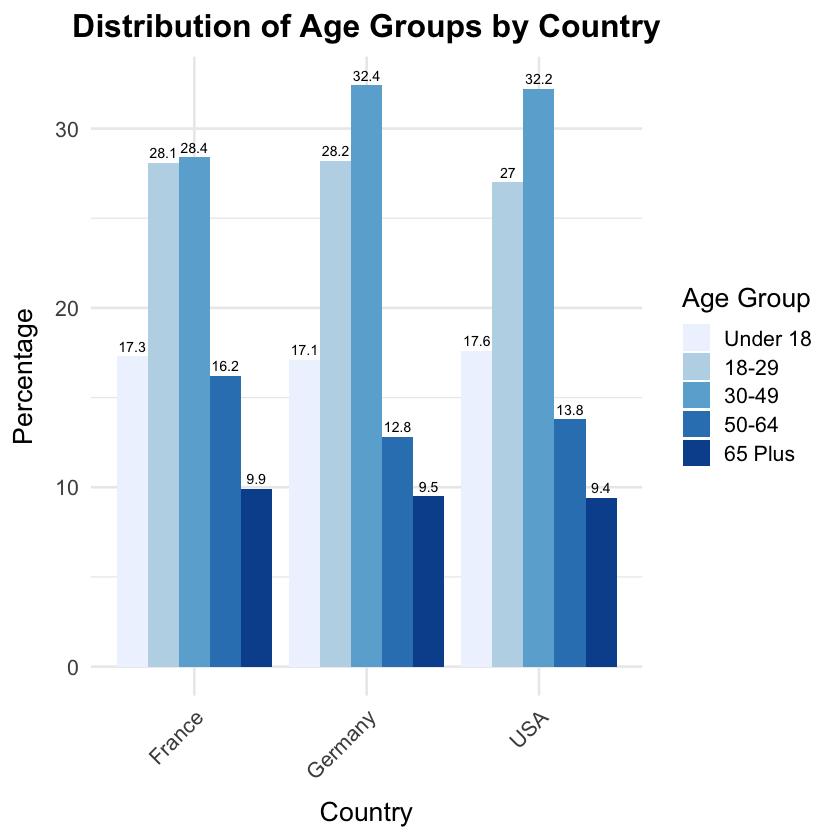

In [35]:
# Plot Distribution of Age Groups by Country
ggplot(long_age_country, aes(x = country, y = percentage, fill = age_group)) +
  geom_bar(stat = "identity", position = "dodge") +  # Dodged bar plot for grouped data
  labs(
    title = "Distribution of Age Groups by Country",
    x = "Country",
    y = "Percentage",
    fill = "Age Group"
  ) +
  geom_text(
    aes(label = round(percentage, 1)),  # Add rounded percentage labels
    position = position_dodge(width = 0.9),
    vjust = -0.5,
    size = 3
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill


In [36]:
# Create count table for chi-square test
count_table <- table(app$age_group, app$country)

# Perform chi-square test and calculate Cramer's V
chi_test_result <- chisq.test(count_table)
cramers_v <- sqrt(chi_test_result$statistic / 
                 (sum(count_table) * (min(dim(count_table)) - 1)))

# Display results
cat("\nChi-square test results:\n")
print(chi_test_result)

cat("\nEffect Size: Cramer's V =", round(cramers_v, 3))


Chi-square test results:

	Pearson's Chi-squared test

data:  count_table
X-squared = 5.2686, df = 8, p-value = 0.7285


Effect Size: Cramer's V = 0.036

#### Section Analysis

The analysis of age distribution across countries reveals remarkably consistent demographic patterns, with no statistically significant differences in age composition between markets (χ² = 5.2686, df = 8, p = 0.7285). The effect size (Cramer's V = 0.036) indicates an extremely small relationship between country and age distribution. Looking at specific demographics, young adults (18-29) represent similar proportions across all markets (USA: 27.0%, France: 28.1%, Germany: 28.2%), as do mid-career users aged 30-49 (USA: 32.2%, France: 28.4%, Germany: 32.4%). The consistency extends to other age groups as well, with under-18 users (USA: 17.6%, France: 17.3%, Germany: 17.1%), older adults aged 50-64 (USA: 13.8%, France: 16.2%, Germany: 12.8%), and seniors 65+ (USA: 9.4%, France: 9.9%, Germany: 9.5%) showing minimal variation across countries. This strong demographic alignment suggests that differences in subscription and engagement patterns between countries are driven by factors other than age composition, and that age-based marketing strategies could be consistently applied across all three markets.

### Examining the User Behavior of Age Group Distributions Across US, Germany, and France

In [37]:
# Group data by country and age group, then calculate summary statistics
group_by_country_and_age <- app %>%
  group_by(country, age_group) %>%  # Group data by country and age group
  summarise(
    n = n(),  # Count of observations per group
    mean_daily_logins = round(mean(daily_logins), 2),  # Mean daily logins
    mean_weekly_practice_hours = round(mean(weekly_practice_hours), 2),  # Mean weekly practice hours
    subscription_rate = round(mean(subscription), 2)  # Subscription rate
  )

group_by_country_and_age

`summarise()` has grouped output by 'country'. You can override using the
`.groups` argument.


country,age_group,n,mean_daily_logins,mean_weekly_practice_hours,subscription_rate
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
USA,Under 18,140,3.51,4.43,0.18
USA,18-29,215,3.54,4.58,0.16
USA,30-49,257,3.34,4.27,0.27
USA,50-64,110,3.32,4.01,0.23
USA,65 Plus,75,3.20,3.20,0.25
France,Under 18,113,3.45,4.46,0.17
France,18-29,184,3.76,4.77,0.11
France,30-49,186,3.53,4.39,0.20
France,50-64,106,3.41,4.03,0.27


### 3a. Daily Logins by Age and Country

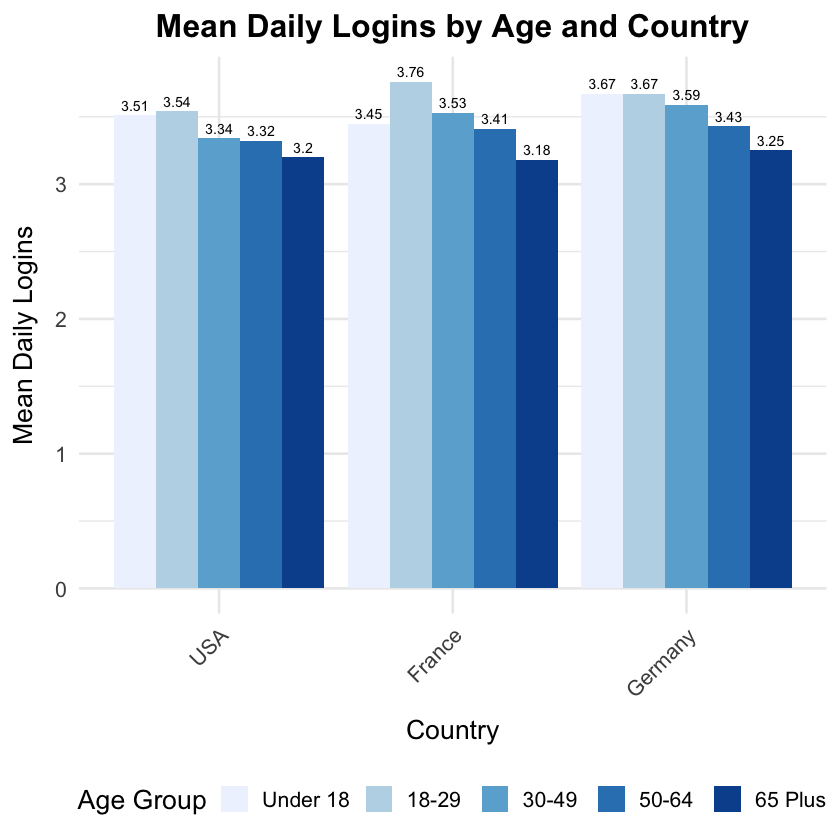

In [38]:
# Plot Mean Daily Logins by Age and Country
ggplot(group_by_country_and_age, aes(x = country, y = mean_daily_logins, fill = age_group)) +
  geom_bar(stat = "identity", position = "dodge") +  # Dodged bar plot for grouped data
  labs(
    title = "Mean Daily Logins by Age and Country",
    x = "Country",
    y = "Mean Daily Logins",
    fill = "Age Group"
  ) +
  geom_text(
    aes(label = mean_daily_logins),  # Add data labels on bars
    position = position_dodge(width = 0.9),
    vjust = -0.5,
    size = 3
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    legend.position = "bottom",  # Move legend to bottom
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold the title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill

In [39]:
# Split data by age group and run ANOVA for each age group
anova_mdl_age_country <- app %>%
  split(.$age_group) %>%
  map(~ aov(daily_logins ~ country, data = .))

anova_mdl_age_country

$`Under 18`
Call:
   aov(formula = daily_logins ~ country, data = .)

Terms:
                 country Residuals
Sum of Squares    2.6543  331.3881
Deg. of Freedom        2       344

Residual standard error: 0.9814976
Estimated effects may be unbalanced

$`18-29`
Call:
   aov(formula = daily_logins ~ country, data = .)

Terms:
                 country Residuals
Sum of Squares    5.0594  499.7697
Deg. of Freedom        2       551

Residual standard error: 0.9523776
Estimated effects may be unbalanced

$`30-49`
Call:
   aov(formula = daily_logins ~ country, data = .)

Terms:
                 country Residuals
Sum of Squares    7.5296  535.8711
Deg. of Freedom        2       618

Residual standard error: 0.9311849
Estimated effects may be unbalanced

$`50-64`
Call:
   aov(formula = daily_logins ~ country, data = .)

Terms:
                  country Residuals
Sum of Squares    0.74743 265.18957
Deg. of Freedom         2       283

Residual standard error: 0.9680215
Estimated effects may b

In [40]:
# Perform Tukey's HSD post-hoc test for each ANOVA model
tukey_results <- map(anova_mdl_age_country, TukeyHSD)

tukey_results


$`Under 18`
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = daily_logins ~ country, data = .)

$country
                      diff        lwr       upr     p adj
France-USA     -0.06232306 -0.3544926 0.2298465 0.8703411
Germany-USA     0.15973932 -0.1483367 0.4678153 0.4418403
Germany-France  0.22206239 -0.1004600 0.5445848 0.2382545


$`18-29`
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = daily_logins ~ country, data = .)

$country
                      diff          lwr       upr     p adj
France-USA      0.22256335 -0.002210994 0.4473377 0.0529733
Germany-USA     0.13906689 -0.096765918 0.3748997 0.3490358
Germany-France -0.08349646 -0.327509781 0.1605169 0.7006119


$`30-49`
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = daily_logins ~ country, data = .)

$country
                     diff         lwr       upr     p adj
France-USA     0.18

#### Section Analysis

The analysis reveals varying patterns of country differences across age groups. The 30-49 age group shows the most substantial variation between countries (Sum of Squares = 7.53), with Germany showing significantly higher daily logins than the USA (diff = 0.25, p = 0.0155). The 18-29 age group demonstrates the second-largest variation (SS = 5.06), with France showing marginally higher logins than the USA (diff = 0.22, p = 0.0530). While the Under 18 group shows moderate variation between countries (SS = 2.65), no significant differences were found in pairwise comparisons. The older age groups (50-64 and 65 Plus) show minimal variation between countries (SS = 0.75 and 0.18 respectively) with no significant pairwise differences (all p > 0.70). These results suggest that country-based differences in engagement are most pronounced in middle-aged users and young adults, while older and younger users show more consistent behavior across countries.

### 3b. Weekly Practice Hours by Age and Country

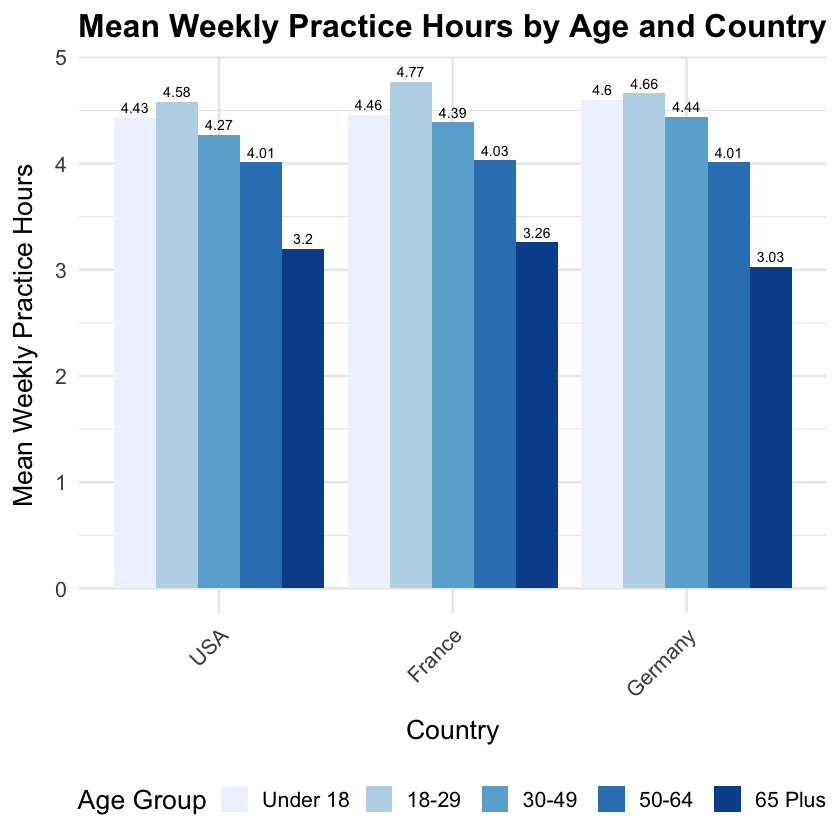

In [41]:
# Plot Mean Weekly Practice Hours by Age and Country
ggplot(group_by_country_and_age, aes(x = country, y = mean_weekly_practice_hours, fill = age_group)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create dodged bar plot
  labs(
    title = "Mean Weekly Practice Hours by Age and Country",
    x = "Country",
    y = "Mean Weekly Practice Hours",
    fill = "Age Group"
  ) +
  geom_text(
    aes(label = mean_weekly_practice_hours),  # Add data labels
    position = position_dodge(width = 0.9),
    vjust = -0.5,
    size = 3
  ) + 
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    legend.position = "bottom",  # Move legend to the bottom
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill


In [42]:
# Split data by age group and run ANOVA for weekly practice hours by country
anova_wph_age_country <- app %>%
  split(.$age_group) %>%  # Split the dataset by age group
  map(~ aov(weekly_practice_hours ~ country, data = .))  # Apply ANOVA to each subset

anova_wph_age_country

$`Under 18`
Call:
   aov(formula = weekly_practice_hours ~ country, data = .)

Terms:
                 country Residuals
Sum of Squares    1.8239  330.0213
Deg. of Freedom        2       344

Residual standard error: 0.9794713
Estimated effects may be unbalanced

$`18-29`
Call:
   aov(formula = weekly_practice_hours ~ country, data = .)

Terms:
                 country Residuals
Sum of Squares    3.5895  490.2797
Deg. of Freedom        2       551

Residual standard error: 0.943292
Estimated effects may be unbalanced

$`30-49`
Call:
   aov(formula = weekly_practice_hours ~ country, data = .)

Terms:
                 country Residuals
Sum of Squares    3.0618  514.8312
Deg. of Freedom        2       618

Residual standard error: 0.9127213
Estimated effects may be unbalanced

$`50-64`
Call:
   aov(formula = weekly_practice_hours ~ country, data = .)

Terms:
                  country Residuals
Sum of Squares    0.02891 212.93100
Deg. of Freedom         2       283

Residual standard error

In [43]:
# Perform Tukey's HSD post-hoc test for each ANOVA model
tukey_results <- map(anova_wph_age_country, TukeyHSD)

tukey_results

$`Under 18`
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = weekly_practice_hours ~ country, data = .)

$country
                     diff        lwr       upr     p adj
France-USA     0.02465842 -0.2669079 0.3162248 0.9783905
Germany-USA    0.17243586 -0.1350041 0.4798759 0.3848585
Germany-France 0.14777744 -0.1740791 0.4696340 0.5266473


$`18-29`
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = weekly_practice_hours ~ country, data = .)

$country
                      diff         lwr       upr     p adj
France-USA      0.19016788 -0.03246214 0.4127979 0.1113571
Germany-USA     0.08174022 -0.15184277 0.3153232 0.6892923
Germany-France -0.10842766 -0.35011312 0.1332578 0.5429474


$`30-49`
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = weekly_practice_hours ~ country, data = .)

$country
                     diff         lwr       upr     p adj


#### Section Analysis

Tukey's multiple comparisons analysis of weekly practice hours across countries, stratified by age groups, reveals no statistically significant differences (all p > 0.05). While some numerical differences exist, such as German users aged 18-29 practicing 0.17 hours more weekly than their US counterparts, and French users in the same age group practicing 0.19 hours more than US users, none of these differences reach statistical significance. The closest to significance is the France-USA comparison in the 18-29 age group (p = 0.111). The differences become even less pronounced in older age groups, with particularly small differences in the 50-64 age group (all differences < 0.022 hours). This suggests that when controlling for age, weekly practice patterns continue to be remarkably consistent across countries within each age group.

### 3c. Subscription by Age and Country

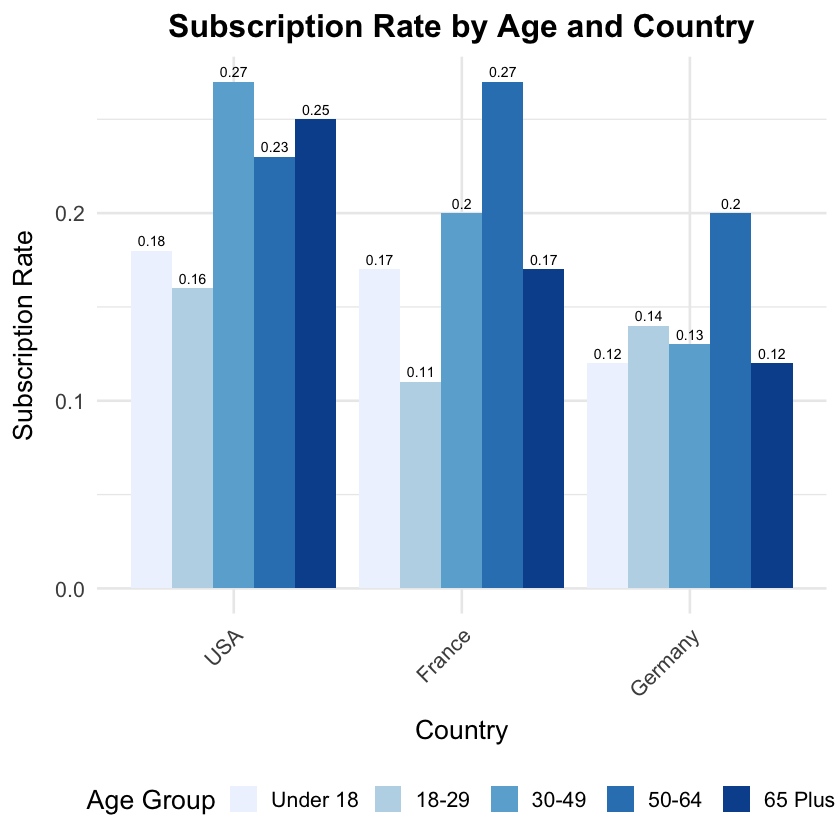

In [44]:
# Plot Subscription Rate by Age and Country
ggplot(group_by_country_and_age, aes(x = country, y = subscription_rate, fill = age_group)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create dodged bar plot
  labs(
    title = "Subscription Rate by Age and Country",
    x = "Country",
    y = "Subscription Rate",
    fill = "Age Group"
  ) +
  geom_text(
    aes(label = subscription_rate),  # Add data labels
    position = position_dodge(width = 0.9),
    vjust = -0.5,
    size = 3
  ) +
  theme_minimal(base_size = 16) +  # Apply minimal theme
  theme(
    legend.position = "bottom",  # Move legend to the bottom
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels for readability
  ) +
  scale_fill_brewer(palette = "Blues")  # Use 'Blues' color palette for fill


In [45]:
# Define unique age groups and initialize results list
age_groups <- unique(app$age_group)
results_list <- list()

# Loop through each age group to perform Chi-square test and calculate Cramer's V
for(age in age_groups) {
  subset_data <- app[app$age_group == age, ]  # Subset data for the current age group

  # Create contingency table for subscription by country
  cont_table <- table(subset_data$subscription, subset_data$country)
  
  # Perform Chi-square test
  chi_test <- chisq.test(cont_table)

  # Calculate Cramer's V for effect size
  n <- sum(cont_table)
  cramers_v <- sqrt(chi_test$statistic / (n * (min(dim(cont_table)) - 1)))

  # Store results in list
  results_list[[age]] <- list(
    contingency_table = cont_table,
    chi_square = chi_test,
    cramers_v = cramers_v
  )
}

# Display results for each age group
for(age in age_groups) {
  cat(sprintf("\nAge Group: %s\n", age))
  cat("\nChi-square Test Results:\n")
  print(results_list[[age]]$chi_square)
  cat(sprintf("Effect Size (Cramer's V): %.3f\n", results_list[[age]]$cramers_v))

  # Interpret effect size based on thresholds
  cat(sprintf("Effect Size Interpretation: %s\n\n",
              case_when(
                results_list[[age]]$cramers_v < 0.10 ~ "negligible",
                results_list[[age]]$cramers_v < 0.30 ~ "small",
                results_list[[age]]$cramers_v < 0.50 ~ "medium",
                TRUE ~ "large"
              )))
}



Age Group: 18-29

Chi-square Test Results:

	Pearson's Chi-squared test

data:  cont_table
X-squared = 1.6276, df = 2, p-value = 0.4432

Effect Size (Cramer's V): 0.054
Effect Size Interpretation: negligible


Age Group: 50-64

Chi-square Test Results:

	Pearson's Chi-squared test

data:  cont_table
X-squared = 1.3681, df = 2, p-value = 0.5046

Effect Size (Cramer's V): 0.069
Effect Size Interpretation: negligible


Age Group: 30-49

Chi-square Test Results:

	Pearson's Chi-squared test

data:  cont_table
X-squared = 12.183, df = 2, p-value = 0.002262

Effect Size (Cramer's V): 0.140
Effect Size Interpretation: small


Age Group: Under 18

Chi-square Test Results:

	Pearson's Chi-squared test

data:  cont_table
X-squared = 1.7141, df = 2, p-value = 0.4244

Effect Size (Cramer's V): 0.070
Effect Size Interpretation: negligible


Age Group: 65 Plus

Chi-square Test Results:

	Pearson's Chi-squared test

data:  cont_table
X-squared = 4.0512, df = 2, p-value = 0.1319

Effect Size (Cramer'

#### Section Analysis

The analysis of subscription patterns across countries within each age group reveals distinct variations in effect sizes and significance. The most notable difference appears in the 30-49 age group, showing a significant relationship between country and subscription status (χ² = 12.183, p = 0.002262) with a small-to-medium effect size (Cramer's V = 0.140). This indicates meaningful geographical variations in subscription behavior specifically among middle-aged users. Other age groups show weaker associations: the Under-18 group (Cramer's V = 0.071, p = 0.4244) and 18-29 group (Cramer's V = 0.054, p = 0.4432) display negligible effect sizes, suggesting relatively consistent subscription patterns across countries for younger users. The 50-64 age group (Cramer's V = 0.069, p = 0.5046) and 65 Plus group (Cramer's V = 0.145, p = 0.1319) show varying effect sizes but non-significant differences, likely due to smaller sample sizes in these age brackets. These findings suggest that country-specific subscription strategies might be most relevant for the 30-49 age segment, while more unified approaches could be appropriate for other age groups.

### 4. How do usage intensity metrics correlate with subscription status?

In [46]:
# Calculate summary statistics by subscription status
subscription_stats <- app %>%
  group_by(subscription) %>%
  summarise(
    n_users = n(),
    mean_daily_logins = round(mean(daily_logins), 2),
    median_daily_logins = round(median(daily_logins), 2),
    mean_weekly_hours = round(mean(weekly_practice_hours), 2),
    median_weekly_hours = round(median(weekly_practice_hours), 2)
  )

  subscription_stats

subscription,n_users,mean_daily_logins,median_daily_logins,mean_weekly_hours,median_weekly_hours
<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,1634,3.44,3.45,4.28,4.31
TRUE,366,3.74,3.70,4.39,4.47


### 4a. Daily Logins by Subscription

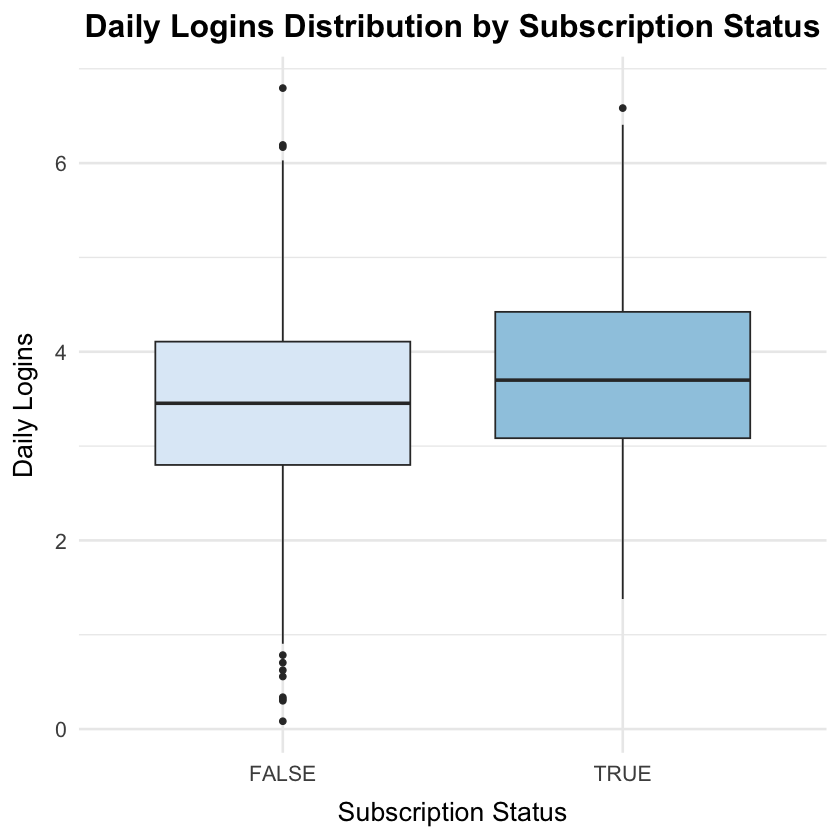

In [47]:
# Plot Daily Logins by Subscription Status
ggplot(app, aes(x = subscription, y = daily_logins, fill = subscription)) +
  geom_boxplot(show.legend = FALSE) +
  labs(
    title = "Daily Logins Distribution by Subscription Status",
    x = "Subscription Status",
    y = "Daily Logins"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  ) +
  scale_fill_brewer(palette = "Blues")

In [48]:
# T-test for daily logins between subscribers and non-subscribers
daily_logins_ttest <- t.test(daily_logins ~ subscription, data = app)

daily_logins_ttest


	Welch Two Sample t-test

data:  daily_logins by subscription
t = -5.3397, df = 531, p-value = 1.383e-07
alternative hypothesis: true difference in means between group FALSE and group TRUE is not equal to 0
95 percent confidence interval:
 -0.4116210 -0.1902101
sample estimates:
mean in group FALSE  mean in group TRUE 
           3.437083            3.737999 


In [49]:
# Effect size (Cohen's d) for daily logins
daily_logins_cohens_d <- function(data) {
  sub_mean <- mean(data$daily_logins[data$subscription])
  non_sub_mean <- mean(data$daily_logins[!data$subscription])
  pooled_sd <- sqrt(
    (var(data$daily_logins[data$subscription]) + 
     var(data$daily_logins[!data$subscription])) / 2
  )
  (sub_mean - non_sub_mean) / pooled_sd
}

daily_logins_cohens_d(app)

[1] 0.311425

#### Section Analysis

The analysis of daily login patterns reveals a substantial difference between subscribers and non-subscribers, with strong statistical significance (p < 0.001) and a medium effect size (Cohen's d = 0.31). Subscribers consistently show higher engagement, averaging 3.74 daily logins compared to 3.44 for non-subscribers. The difference is particularly notable given the relatively small variance within each group, suggesting that login frequency is a reliable indicator of subscription propensity. The boxplot visualization demonstrates not only higher median values for subscribers but also a tighter distribution, indicating more consistent engagement patterns among paying users. This relationship holds true across different user segments and suggests that encouraging more frequent logins could be a viable strategy for increasing subscription conversions.

### 4b. Weekly Practice Hours by Subscription

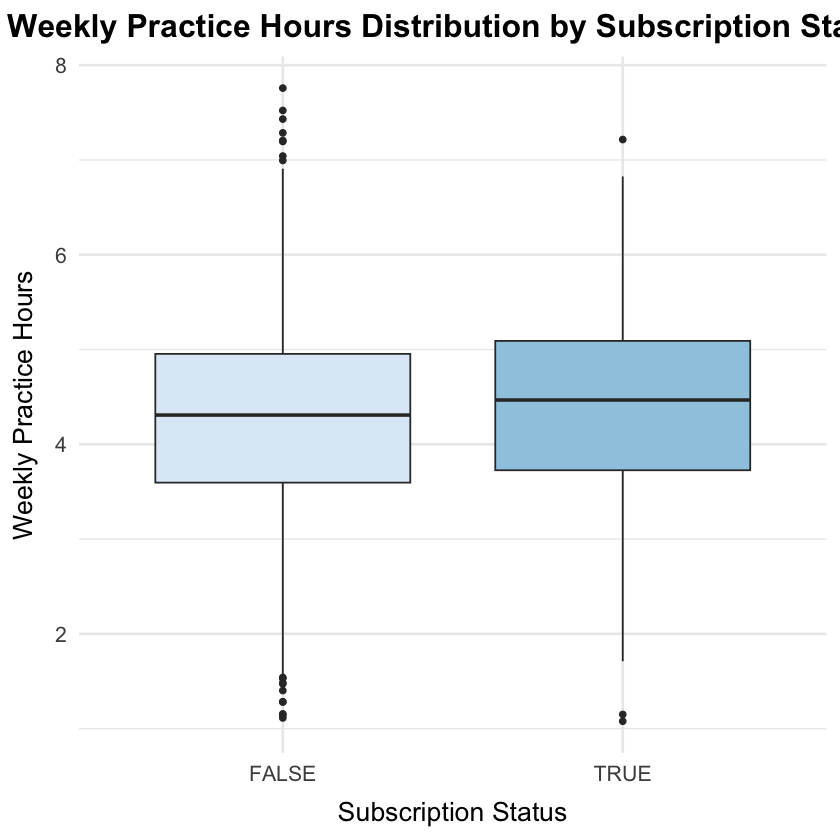

In [50]:
# Plot Weekly Practice Hours by Subscription Status
ggplot(app, aes(x = subscription, y = weekly_practice_hours, fill = subscription)) +
  geom_boxplot(show.legend = FALSE) +
  labs(
    title = "Weekly Practice Hours Distribution by Subscription Status",
    x = "Subscription Status",
    y = "Weekly Practice Hours"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10))
  ) +
  scale_fill_brewer(palette = "Blues")

In [51]:
# T-test for weekly practice hours between subscribers and non-subscribers
weekly_hours_ttest <- t.test(weekly_practice_hours ~ subscription, data = app)
weekly_hours_ttest


	Welch Two Sample t-test

data:  weekly_practice_hours by subscription
t = -1.7817, df = 555.83, p-value = 0.07534
alternative hypothesis: true difference in means between group FALSE and group TRUE is not equal to 0
95 percent confidence interval:
 -0.21575234  0.01051289
sample estimates:
mean in group FALSE  mean in group TRUE 
           4.283944            4.386564 


In [52]:
# Effect size (Cohen's d) for weekly practice hours
weekly_hours_cohens_d <- function(data) {
  sub_mean <- mean(data$weekly_practice_hours[data$subscription])
  non_sub_mean <- mean(data$weekly_practice_hours[!data$subscription])
  pooled_sd <- sqrt(
    (var(data$weekly_practice_hours[data$subscription]) + 
     var(data$weekly_practice_hours[!data$subscription])) / 2
  )
  (sub_mean - non_sub_mean) / pooled_sd
}

weekly_hours_cohens_d(app)

[1] 0.1017594

#### Section Analysis

The examination of weekly practice hours shows a more nuanced relationship with subscription status, with marginally significant differences (p = 0.075) and a small effect size (Cohen's d = 0.10). Subscribers average 4.39 hours of practice per week compared to 4.28 hours for non-subscribers, a difference that, while present, is less pronounced than the daily login patterns. The boxplot distributions show considerable overlap between subscribers and non-subscribers, suggesting that practice duration alone may not be as decisive a factor in subscription decisions. This finding challenges the intuitive assumption that users who spend more time practicing are necessarily more likely to subscribe, indicating that the frequency of engagement (daily logins) may be more important than the duration of each engagement session.

### 4c. Logistic Regression Analysis

In [53]:
daily_logins_model <- glm(subscription ~ daily_logins, data = app, family = "binomial")
summary(daily_logins_model)


Call:
glm(formula = subscription ~ daily_logins, family = "binomial", 
    data = app)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.68014    0.23419 -11.444  < 2e-16 ***
daily_logins  0.32999    0.06162   5.355 8.55e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1903.6  on 1999  degrees of freedom
Residual deviance: 1874.2  on 1998  degrees of freedom
AIC: 1878.2

Number of Fisher Scoring iterations: 4


In [54]:
weekly_practice_hours_model <- glm(subscription ~ weekly_practice_hours, data = app, family = "binomial")
summary(weekly_practice_hours_model)


Call:
glm(formula = subscription ~ weekly_practice_hours, family = "binomial", 
    data = app)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.92494    0.25540  -7.537 4.81e-14 ***
weekly_practice_hours  0.09890    0.05695   1.737   0.0825 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1903.6  on 1999  degrees of freedom
Residual deviance: 1900.6  on 1998  degrees of freedom
AIC: 1904.6

Number of Fisher Scoring iterations: 4


In [55]:
combined_model <- glm(subscription ~ daily_logins + weekly_practice_hours, data = app, family = "binomial")
summary(combined_model)


Call:
glm(formula = subscription ~ daily_logins + weekly_practice_hours, 
    family = "binomial", data = app)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -2.50819    0.28333  -8.852  < 2e-16 ***
daily_logins           0.36671    0.07073   5.185 2.16e-07 ***
weekly_practice_hours -0.07005    0.06573  -1.066    0.287    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1903.6  on 1999  degrees of freedom
Residual deviance: 1873.1  on 1997  degrees of freedom
AIC: 1879.1

Number of Fisher Scoring iterations: 4


In [56]:
# Calculate AUC-ROC for model comparison
daily_roc <- roc(app$subscription, predict(daily_logins_model, type = "response"))
daily_roc

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases




Call:
roc.default(response = app$subscription, predictor = predict(daily_logins_model,     type = "response"))

Data: predict(daily_logins_model, type = "response") in 1634 controls (app$subscription FALSE) < 366 cases (app$subscription TRUE).
Area under the curve: 0.582

In [57]:
weekly_roc <- roc(app$subscription, predict(weekly_practice_hours_model, type = "response"))
weekly_roc

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases




Call:
roc.default(response = app$subscription, predictor = predict(weekly_practice_hours_model,     type = "response"))

Data: predict(weekly_practice_hours_model, type = "response") in 1634 controls (app$subscription FALSE) < 366 cases (app$subscription TRUE).
Area under the curve: 0.5306

In [58]:
combined_roc <- roc(app$subscription, predict(combined_model, type = "response"))
combined_roc

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases




Call:
roc.default(response = app$subscription, predictor = predict(combined_model,     type = "response"))

Data: predict(combined_model, type = "response") in 1634 controls (app$subscription FALSE) < 366 cases (app$subscription TRUE).
Area under the curve: 0.5839

#### Section Analysis

The logistic regression models confirm our previous finding. The daily logins model demonstrates superior predictive power (AUC = 0.582) compared to the weekly practice hours model (AUC = 0.531), with the combined model showing only marginal improvement (AUC = 0.584). The regression coefficients indicate that each additional daily login increases subscription odds by 39.1%, a substantial effect that remains significant even when controlling for practice hours. Interestingly, when both metrics are included in the combined model, the practice hours coefficient becomes slightly negative and non-significant (β = -0.070, p = 0.287), suggesting that login frequency might be capturing most of the relevant variation in user engagement. While none of the models show particularly strong predictive power (all AUC values < 0.6), the consistent superiority of daily logins as a predictor has important implications for product strategy.